<a href="https://colab.research.google.com/github/mudmemeshiba/GenderClassification/blob/main/RestNet-18_GenderClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.) Data Exploration


In [ ]:
  from google.colab import drive #load dataset from my google drive
  drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
  !unzip "/content/drive/My Drive/Project_Deep/Dataset.zip" -d "/content/dataset_folder" #Unzip file from drive

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/dataset_folder/Validation/male/067031.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067038.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067040.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067046.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067048.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067054.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067064.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067068.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067069.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067086.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067091.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067099.jpg.jpg  
  inflating: /content/dataset_folder/Validation/male/067101.jpg.jpg  
  inflating: /content/dataset_fol

In [ ]:
!nvidia-smi -L || true  # ดูว่าได้ GPU ไหม (บน Colab)
import torch, platform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__)
print("Device :", device, "| Python:", platform.python_version())

/bin/bash: line 1: nvidia-smi: command not found
PyTorch: 2.8.0+cu126
Device : cpu | Python: 3.12.12


In [ ]:
import os, json, time, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from PIL import Image

In [ ]:
BASE_DIR  = "/content/dataset_folder"   #ใส่เส้นทางไป Dataset
TRAIN_DIR = os.path.join(BASE_DIR, "Training")
TEST_DIR  = os.path.join(BASE_DIR, "Validation")

IMG_SIZE   = 224
BATCH_SIZE = 32
NUM_WORKERS= 2
SEED       = 1337

torch.manual_seed(SEED)

# แบ่ง val จาก train (ใช้ ImageFolder + Subset)
# สร้าง full dataset ก่อน แล้วค่อย split indices
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
class_names = full_train.classes  # e.g. ['female','male']
num_classes = len(class_names)
print("Classes:", class_names)

# สุ่มแบ่ง train/val
val_ratio = 0.2
num_total = len(full_train)
indices   = np.arange(num_total)
np.random.seed(SEED); np.random.shuffle(indices)
val_size  = int(num_total * val_ratio)
val_idx   = indices[:val_size]
train_idx = indices[val_size:]

train_subset = torch.utils.data.Subset(full_train, train_idx)
val_subset   = torch.utils.data.Subset(datasets.ImageFolder(TRAIN_DIR, transform=test_tfms), val_idx)

# Test dataset
test_set = datasets.ImageFolder(TEST_DIR, transform=test_tfms)

# จัดการ class imbalance (optional): ใช้ WeightedRandomSampler
targets = np.array([full_train.samples[i][1] for i in train_idx])
class_count = np.bincount(targets, minlength=num_classes)
class_weights = 1.0 / (class_count + 1e-6)
sample_weights = class_weights[targets]
sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_weights),
                                num_samples=len(sample_weights),
                                replacement=True)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Classes: ['female', 'male']


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# แทนที่ fully-connected layer ให้รองรับ binary
in_feats = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_feats, 1)  # binary: logit เดียว
)
model = model.to(device)

# Loss & Optimizer & Scheduler
# ใช้ BCEWithLogitsLoss (เพราะ output เป็น logit)
pos_weight = None  # ถ้า class imbalance หนักมาก: pos_weight=torch.tensor([class_weights_index_for_positive]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [ ]:
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

def epoch_run(loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()

    running_loss, running_corrects, count = 0.0, 0, 0
    all_logits, all_labels = [], []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.float().to(device, non_blocking=True)  # [0,1]

        optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(images).squeeze(1)        # shape [B]
                loss = criterion(logits, labels)

            if train_mode:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        preds = (torch.sigmoid(logits) >= 0.5).long()
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds.cpu() == labels.long().cpu()).item()
        count += images.size(0)
        all_logits.append(logits.detach().cpu())
        all_labels.append(labels.detach().cpu())

    avg_loss = running_loss / count
    acc = running_corrects / count
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_labels)

def train_model(epochs=15, patience=5): #กำหนดให้ epoch = 15
    best_w = copy.deepcopy(model.state_dict())
    best_metric = -np.inf
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    no_improve = 0

    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc, _, _ = epoch_run(train_loader, train_mode=True)
        val_loss, val_acc, _, _ = epoch_run(val_loader, train_mode=False)
        scheduler.step(val_loss)

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)

        print(f"Epoch {ep:02d} | "
              f"train_loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val_loss {val_loss:.4f} acc {val_acc:.4f} | "
              f"time {(time.time()-t0):.1f}s")

        # ใช้ val_acc เป็นเกณฑ์ (จะใช้ val_auc ก็ได้ถ้าคำนวณเพิ่ม)
        if val_acc > best_metric:
            best_metric = val_acc
            best_w = copy.deepcopy(model.state_dict())
            no_improve = 0
            torch.save(model.state_dict(), "/content/best_resnet18_gender.pth")
            print("  ↳ Saved best weights")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {ep}")
                break

    model.load_state_dict(best_w)
    return history

history = train_model(epochs=15, patience=5)

/tmp/ipython-input-3383487031.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
/tmp/ipython-input-3383487031.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01 | train_loss 0.1173 acc 0.9575 | val_loss 0.0934 acc 0.9714 | time 199.4s
  ↳ Saved best weights
Epoch 02 | train_loss 0.0806 acc 0.9723 | val_loss 0.0851 acc 0.9718 | time 183.9s
  ↳ Saved best weights
Epoch 03 | train_loss 0.0718 acc 0.9752 | val_loss 0.0864 acc 0.9731 | time 181.1s
  ↳ Saved best weights
Epoch 04 | train_loss 0.0583 acc 0.9804 | val_loss 0.0911 acc 0.9736 | time 184.4s
  ↳ Saved best weights
Epoch 05 | train_loss 0.0532 acc 0.9814 | val_loss 0.0872 acc 0.9701 | time 189.9s
Epoch 06 | train_loss 0.0361 acc 0.9876 | val_loss 0.0916 acc 0.9731 | time 183.0s
Epoch 07 | train_loss 0.0300 acc 0.9894 | val_loss 0.0857 acc 0.9722 | time 191.9s
Epoch 08 | train_loss 0.0240 acc 0.9913 | val_loss 0.0994 acc 0.9714 | time 183.8s
Epoch 09 | train_loss 0.0181 acc 0.9941 | val_loss 0.0986 acc 0.9737 | time 188.7s
  ↳ Saved best weights
Epoch 10 | train_loss 0.0112 acc 0.9962 | val_loss 0.1109 acc 0.9738 | time 187.1s
  ↳ Saved best weights
Epoch 11 | train_loss 0.0100 acc

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = True  # จูนทั้งหมด (ถ้าอยากแค่ layer หลัง ๆ ก็กรองชื่อ)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

history_ft = train_model(epochs=8, patience=4) #จูนอีก 8 epochs

/tmp/ipython-input-3383487031.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01 | train_loss 0.0033 acc 0.9992 | val_loss 0.1265 acc 0.9742 | time 195.1s
  ↳ Saved best weights
Epoch 02 | train_loss 0.0032 acc 0.9990 | val_loss 0.1273 acc 0.9738 | time 185.1s
Epoch 03 | train_loss 0.0027 acc 0.9992 | val_loss 0.1351 acc 0.9747 | time 186.0s
  ↳ Saved best weights
Epoch 04 | train_loss 0.0019 acc 0.9994 | val_loss 0.1421 acc 0.9733 | time 182.7s
Epoch 05 | train_loss 0.0013 acc 0.9997 | val_loss 0.1413 acc 0.9744 | time 187.6s
Epoch 06 | train_loss 0.0010 acc 0.9998 | val_loss 0.1446 acc 0.9738 | time 179.7s
Epoch 07 | train_loss 0.0010 acc 0.9998 | val_loss 0.1365 acc 0.9739 | time 185.5s
Early stopping at epoch 7


In [ ]:
#คำนวณ Confusion Matrix
model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images).squeeze(1)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu().float())

logits = torch.cat(all_logits)
labels = torch.cat(all_labels)
probs  = torch.sigmoid(logits).numpy()
preds  = (probs >= 0.5).astype(int)

print(classification_report(labels.numpy().astype(int), preds, target_names=class_names))

cm = confusion_matrix(labels.numpy().astype(int), preds)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

      female       0.97      0.98      0.98      5841
        male       0.98      0.97      0.98      5808

    accuracy                           0.98     11649
   macro avg       0.98      0.98      0.98     11649
weighted avg       0.98      0.98      0.98     11649

Confusion Matrix:
 [[5742   99]
 [ 174 5634]]


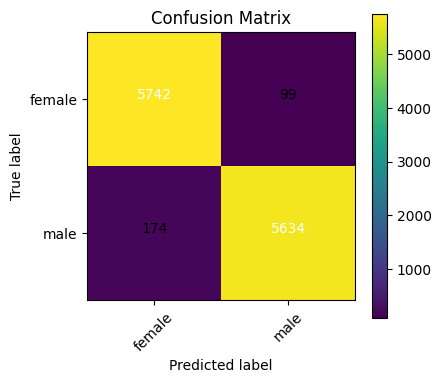

In [ ]:
def plot_cm(cm, classes):
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
    plt.show()

plot_cm(cm, class_names)

In [ ]:
save_path = "/content/resnet18_gender.pth"
torch.save(model.state_dict(), save_path)
with open("/content/class_names.json", "w") as f:
    json.dump(class_names, f)
print("Saved:", save_path, "and class_names.json")

#โหลดตัวโมเดลเก็บไว้

NameError: name 'model' is not defined

In [ ]:
import os, torch, torch.nn as nn
from torchvision import models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = "/content/best_resnet18_gender.pth"

assert os.path.exists(ckpt) and os.path.getsize(ckpt) > 1024, "ไฟล์เช็กพอยต์ไม่มี/เสีย"
try:
    state = torch.load(ckpt, map_location="cpu")
except Exception as e:
    print("โหลดแบบ state_dict ไม่ได้:", e)
    try:
        scripted = torch.jit.load(ckpt, map_location="cpu")
        model = scripted.to(DEVICE).eval()
        print("โหลดเป็น TorchScript สำเร็จ")
    except Exception as e2:
        raise RuntimeError(f"โหลดไม่ได้ทั้งสองแบบ: {e2}")

# ถ้าได้ state_dict มา (dict)
if isinstance(globals().get("state"), dict):
    # เผื่อกรณีเช็กพอยต์มีคีย์ 'state_dict'
    if "state_dict" in state:
        state = state["state_dict"]

    # สร้างสถาปัตย์เดิม (ResNet18 + fc = 1)
    model = models.resnet18(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_feats, 1))

    missing, unexpected = model.load_state_dict(state, strict=False)
    print("missing keys:", missing)
    print("unexpected keys:", unexpected)

    model = model.to(DEVICE).eval()
    print("✅ โหลด state_dict สำเร็จ")

missing keys: []
unexpected keys: []
✅ โหลด state_dict สำเร็จ


In [ ]:
model = models.resnet18(weights=None)
in_feats = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_feats, 1))
model.load_state_dict(torch.load("/content/best_resnet18_gender.pth", map_location="cpu"))
model.eval()

IMG_SIZE = 224
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
class_names = ['female','male']
path = '/content/Tak.jpeg' #ใส่ Path เพื่องลอง
def predict_image(path):
    img = Image.open(path).convert("RGB")
    x = test_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x).squeeze(1)
        prob = torch.sigmoid(logit).item()
    pred = int(prob >= 0.5)
    return class_names[pred], prob
print(predict_image(path))

('male', 0.9296383261680603)
